## Detection Malicious URL Using ML Models and Data Preparation 

In [1]:
!pip install tld
# Framework to Extract the top level domain (TLD) from the URL given.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 15.8 MB/s eta 0:00:00


# Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tld import get_tld
import joblib

# Data Set

In [3]:
data = pd.read_csv('/kaggle/input/dataset-malicious-urls/malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,legitimate
2,bopsecrets.org/rexroth/cr/1.htm,legitimate
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [5]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [6]:
count = data.type.value_counts()
count

type
legitimate    428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

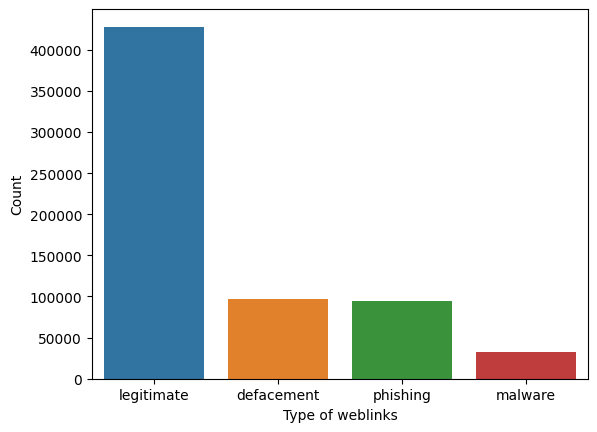

In [7]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Type of weblinks')
plt.ylabel('Count');

omit the (www.) from the URL which is in fact a sub domain in itself

In [8]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,legitimate
2,bopsecrets.org/rexroth/cr/1.htm,legitimate
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [9]:
rem = {"Category": {"legitimate": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

# Feature Extraction

In [10]:
def extract_features(df):
    """
    Extracts various features from the 'url' column in the given DataFrame.
    Parameters:
        df (DataFrame): The input DataFrame with a 'url' column.    
    Returns:
        DataFrame: The DataFrame with additional feature columns.
    """

    # Feature 1: Length of the URL
    df['url_len'] = df['url'].apply(lambda x: len(str(x)))

    # Feature 2: Extract primary domain from URL
    def process_tld(url):
        try:
            res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)
            pri_domain = res.parsed_url.netloc
        except:
            pri_domain = None
        return pri_domain
    df['domain'] = df['url'].apply(lambda i: process_tld(i))

    # Feature 3: Count of special characters in the URL
    special_chars = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']
    for char in special_chars:
        df[char] = df['url'].apply(lambda i: i.count(char))

    # Feature 4: Check if the URL is abnormal (contains hostname outside its domain)
    def abnormal_url(url):
        hostname = urlparse(url).hostname
        hostname = str(hostname)
        match = re.search(hostname, url)
        return 1 if match else 0
    df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

    # Feature 5: Check if the URL uses HTTPS
    def httpSecure(url):
        scheme = urlparse(url).scheme
        return 1 if scheme == 'https' else 0
    df['https'] = df['url'].apply(lambda i: httpSecure(i))

    # Feature 6: Count the number of digits in the URL
    def digit_count(url):
        return sum(1 for i in url if i.isnumeric())
    df['digits'] = df['url'].apply(lambda i: digit_count(i))

    # Feature 7: Count the number of letters in the URL
    def letter_count(url):
        return sum(1 for i in url if i.isalpha())
    df['letters'] = df['url'].apply(lambda i: letter_count(i))

    # Feature 8: Check for URL shortening services
    def Shortining_Service(url):
        shortening_services = re.compile(
            'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
            'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
            'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
            'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
            'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
            'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
            'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
            'tr\.im|link\.zip\.net'
        )
        return 1 if shortening_services.search(url) else 0
    df['Shortining_Service'] = df['url'].apply(lambda x: Shortining_Service(x))

    # Feature 9: Check if the URL contains an IP address
    def having_ip_address(url):
        ip_address_pattern = re.compile(
            r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
            r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
            r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
            r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
            r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)|'
            r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
            r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
            r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'
        )
        return 1 if ip_address_pattern.search(url) else 0
    df['having_ip_address'] = df['url'].apply(lambda i: having_ip_address(i))

    return df


In [11]:
data = extract_features(data)
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,legitimate,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,legitimate,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0


## Save the DataFrame

In [12]:
data.to_csv('dataset_malicious_urls.csv', index=False) # saved if required to be used later

# Train & Test Split

In [13]:
X = data.drop(['url','type','Category','domain'],axis=1)
y = data['Category']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training models

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  90.79%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     85778
           1       0.93      0.96      0.94     19104
           2       0.80      0.57      0.66     18836
           3       0.93      0.91      0.92      6521

    accuracy                           0.91    130239
   macro avg       0.89      0.85      0.87    130239
weighted avg       0.90      0.91      0.90    130239

             Confusion_matrix 


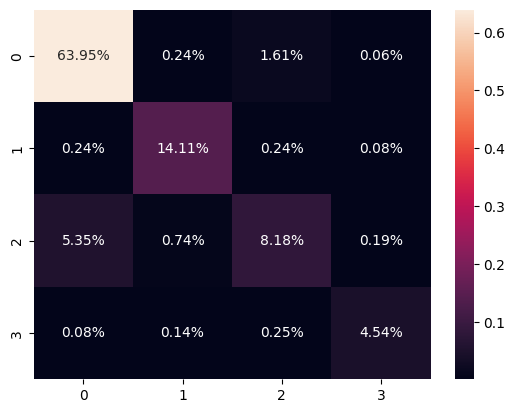

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  91.40%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85778
           1       0.93      0.97      0.95     19104
           2       0.83      0.57      0.68     18836
           3       0.95      0.91      0.93      6521

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239

             Confusion_matrix 


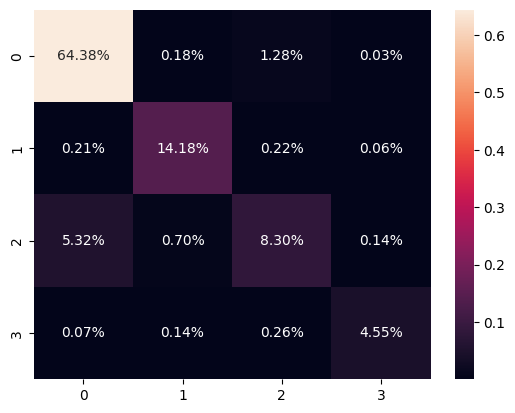

###################- End -###################
#############################################
######-Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  88.97%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     85778
           1       0.89      0.95      0.92     19104
           2       0.74      0.52      0.61     18836
           3       0.93      0.87      0.90      6521

    accuracy                           0.89    130239
   macro avg       0.87      0.82      0.84    130239
weighted avg       0.88      0.89      0.88    130239

             Confusion_matrix 


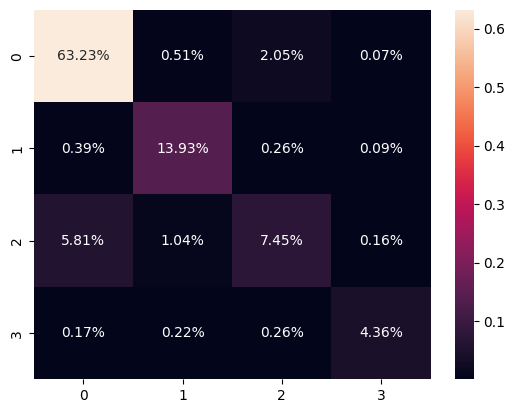

###################- End -###################
#############################################
######-Model => <class 'xgboost.sklearn.XGBClassifier'> 
Test Accuracy :  88.80%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     85778
           1       0.89      0.97      0.93     19104
           2       0.89      0.35      0.50     18836
           3       0.95      0.84      0.89      6521

    accuracy                           0.89    130239
   macro avg       0.90      0.79      0.81    130239
weighted avg       0.89      0.89      0.87    130239

             Confusion_matrix 


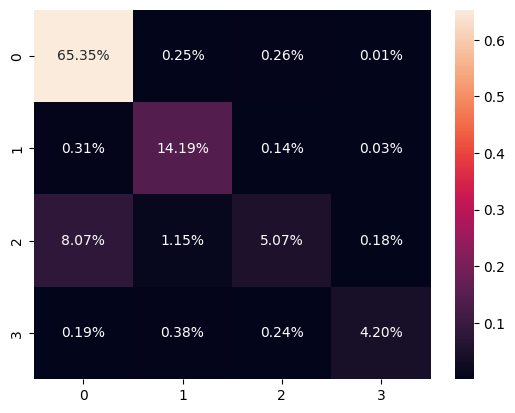

###################- End -###################


In [15]:
models = [DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier, XGBClassifier]
accuracy_test = []

for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))

    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)

    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))

    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))

    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt= '0.2%')
    plt.show()

    # Save the trained model
    model_name = f"{type(model_).__name__}_model.pkl" 
    joblib.dump(model_, model_name) 

    print('\033[31m###################- End -###################\033[0m')

# Comparison Report

In [16]:
report = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'KNeighbors Classifier','XGB Classifier'],
                      "Accuracy":accuracy_test})
report

,Model,Accuracy
0,Decision Tree Classifier,0.907892
1,Random Forest Classifier,0.914012
2,KNeighbors Classifier,0.889687
3,XGB Classifier,0.888021


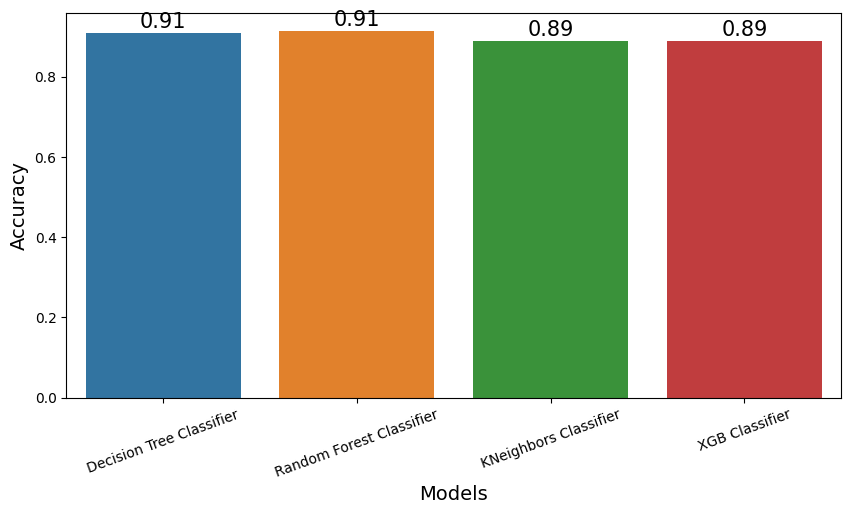

In [17]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=report)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()